In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  64
  On-line CPU(s) list:   0-63
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8358 CPU @ 2.60GHz
    CPU family:          6
    Model:               106
    Thread(s) per core:  1
    Core(s) per socket:  32
    Socket(s):           2
    Stepping:            6
    CPU max MHz:         3400.0000
    CPU min MHz:         800.0000
    BogoMIPS:            5200.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf pni pclmulqdq dtes64 monito

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import time
import seaborn as sns
from scipy.optimize import fmin, minimize, LinearConstraint, Bounds

from efficient_fpt.multi_stage_cy import compute_loss_parallel, print_num_threads


data = pickle.load(open("addm_data_20250924-002142.pkl", "rb"))

In [3]:
CYTHON_TYPE = np.float64

a = data["a"]
b = data["b"]
x0 = data["x0"]
# mu1_true = data["mu1"]
# mu2_true = data["mu2"]
theta_true = data["eta"]
delta_true = data["kappa"]
r1_data = data["r1_data"]
r2_data = data["r2_data"]
flag_data = data["flag_data"].astype(np.int32)

sigma = data["sigma"]
T = data["T"]

mu1_true_data = delta_true * (r1_data - theta_true * r2_data)
mu2_true_data = delta_true * (r2_data - theta_true * r1_data)

mu_true_data = data["mu_array_padded_data"].astype(CYTHON_TYPE)
sacc_data = data["sacc_array_padded_data"].astype(CYTHON_TYPE)
length_data = data["d_data"].astype(np.int32)
rt_data = data["decision_data"][:, 0].astype(CYTHON_TYPE)
choice_data = data["decision_data"][:, 1].astype(np.int32)

num_data, max_d = mu_true_data.shape
# # set data range if necessary
# start_index, end_index = 0, 50000
# num_data = min(end_index, num_data) - min(start_index, num_data)
# mu_array_true_data, mu1_true_data, mu2_true_data, sacc_array_data, length_data, rt_data, choice_data, flag_data = (
#     mu_array_true_data[indices_range],
#     mu1_true_data[indices_range],
#     mu2_true_data[indices_range],
#     sacc_array_data[indices_range],
#     length_data[indices_range],
#     rt_data[indices_range],
#     choice_data[indices_range],
#     flag_data[indices_range],
# )

In [4]:
num_iter = 10
start_time = time.time()
for _ in range(num_iter):
    loss = compute_loss_parallel(
        mu1_true_data,
        mu2_true_data,
        rt_data,
        choice_data,
        flag_data,
        sacc_data,
        length_data,
        max_d,
        sigma,
        a,
        b,
        x0,
    )
end_time = time.time()
print(f"Likelihood evaluation time: {(end_time - start_time) / num_iter:.3f} s")

Likelihood evaluation time: 0.238 s


### Maximum Likelihood Estimation

In [5]:
print("\n")
print_num_threads()
print("# data =", num_data)

# Constraint optimization for searching all parameters
print("\nNumerical optimization for theta, delta, a, b, x0:")
method = "trust-constr"
print("Using " + method)
func = lambda paras: compute_loss_parallel(
    paras[1] * (r1_data - paras[0] * r2_data),
    paras[1] * (r2_data - paras[0] * r1_data),
    rt_data,
    choice_data,
    flag_data,
    sacc_data,
    length_data,
    max_d,
    sigma,
    paras[2],
    paras[3],
    paras[4],
)
bounds = Bounds([0, 0, 0, 0, -np.inf], [1, np.inf, np.inf, np.inf, np.inf])
con = LinearConstraint(
    [[0, 0, 1, -np.max(rt_data), 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, -1]],
    lb=[0, 0, 0],
    ub=[np.inf, np.inf, np.inf],
)
initial_guess = [0.5, 1, 1.0, 0.0, 0.0]
print("Initial guess:", initial_guess)
print()
start_time = time.time()
paras_opt_result = minimize(
    func,
    x0=initial_guess,
    bounds=bounds,
    constraints=con,
    method=method,
    options={"verbose": 1},
)
print(f"Total time: {time.time() - start_time:.3f} seconds")
print(paras_opt_result)



Number of available threads: 64
# data = 50000

Numerical optimization for theta, delta, a, b, x0:
Using trust-constr
Initial guess: [0.5, 1, 1.0, 0.0, 0.0]

`gtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 222, CG iterations: 121, optimality: 9.90e-09, constraint violation: 0.00e+00, execution time: 5.1e+01 s.
Total time: 52.638 seconds
           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.726588378683403
                 x: [ 7.031e-01  5.064e-01  2.110e+00  3.018e-01 -1.948e-01]
               nit: 46
              nfev: 222
              njev: 37
              nhev: 0
          cg_niter: 121
      cg_stop_cond: 1
              grad: [-1.341e-07  0.000e+00  3.532e-08 -1.490e-07  1.490e-08]
   lagrangian_grad: [-7.946e-09 -4.127e-09 -5.471e-09 -8.671e-10  9.897e-09]
            constr: [array([ 3.174e-01,  1.915e+00,  2.304e+00]), array([ 7.031e-01,  5.064e-01,  2

In [6]:
mle = paras_opt_result["x"]
print("True and estimated value of parameters:")
print(f"theta: {theta_true:.5f}, {mle[0]:.5f}")
print(f"delta: {delta_true:.5f}, {mle[1]:.5f}")
print(f"a: {a:.5f}, {mle[2]:.5f}")
print(f"b: {b:.5f}, {mle[3]:.5f}")
print(f"x0: {x0:.5f}, {mle[4]:.5f}")

True and estimated value of parameters:
theta: 0.70000, 0.70314
delta: 0.50000, 0.50635
a: 2.10000, 2.10968
b: 0.30000, 0.30184
x0: -0.20000, -0.19476


In [7]:
n_boot = 1000
alpha = 0.05  # 95% confidence interval

start_time = time.time()
bootstrap_estimates = np.zeros((n_boot, 5))
# Bootstrap resampling
for i in range(n_boot):
    if i % 100 == 0:
        print(f"Bootstrap iteration {i} takes {time.time() - start_time:.3f} seconds")
    indices = np.random.choice(len(rt_data), size=len(rt_data), replace=True)
    # Resample data
    r1_boot = r1_data[indices]
    r2_boot = r2_data[indices]
    rt_boot = rt_data[indices]
    choice_boot = choice_data[indices]
    flag_boot = flag_data[indices]
    sacc_boot = sacc_data[indices, :]
    length_boot = length_data[indices]
    # Define the function for resampled data
    func_boot = lambda paras: compute_loss_parallel(
        paras[1] * (r1_boot - paras[0] * r2_boot),
        paras[1] * (r2_boot - paras[0] * r1_boot),
        rt_boot,
        choice_boot,
        flag_boot,
        sacc_boot,
        length_boot,
        max_d,
        sigma,
        paras[2],
        paras[3],
        paras[4],
    )
    # Optimize for bootstrap sample
    result = minimize(func_boot, x0=mle, bounds=bounds, constraints=con, method=method)
    if result.success:
        bootstrap_estimates[i, :] = result.x
    else:
        print(f"Warning: Optimization failed for bootstrap iteration {i}")

print(f"Total time: {time.time() - start_time:.3f} seconds")
# np.save("bootstrap_estimates.npy", bootstrap_estimates)

Bootstrap iteration 0 takes 0.000 seconds
Bootstrap iteration 100 takes 8499.244 seconds
Bootstrap iteration 200 takes 16595.819 seconds
Bootstrap iteration 300 takes 25018.740 seconds
Bootstrap iteration 400 takes 33798.788 seconds
Bootstrap iteration 500 takes 42766.295 seconds
Bootstrap iteration 600 takes 51071.916 seconds
Bootstrap iteration 700 takes 59483.389 seconds
Bootstrap iteration 800 takes 67682.518 seconds
Bootstrap iteration 900 takes 76495.621 seconds
Total time: 84439.179 seconds


In [8]:
np.save("bootstrap_" + time.strftime("%Y%m%d-%H%M%S") + ".npy", bootstrap_estimates)

In [9]:
# Compute percentiles for pivotal confidence intervals
bootstrap_means = np.mean(bootstrap_estimates, axis=0)
lower_pivot = 2 * bootstrap_means - np.percentile(bootstrap_estimates, 100 * (1 - alpha / 2), axis=0)
upper_pivot = 2 * bootstrap_means - np.percentile(bootstrap_estimates, 100 * (alpha / 2), axis=0)

# Store results
bootstrap_ci = np.vstack((lower_pivot, upper_pivot)).T

In [10]:
bootstrap_ci

array([[ 0.69773088,  0.70906065],
       [ 0.49961833,  0.51314414],
       [ 2.09918562,  2.12033743],
       [ 0.29794384,  0.30601243],
       [-0.20726814, -0.1824141 ]])

##### prior

In [11]:
from scipy.stats import beta, lognorm, gamma


def log_prior(z):
    M = float(max(rt_data))
    theta, delta, a, b, x0 = z
    # --- hard constraints ---
    if not (0.0 < theta < 1.0):
        return -np.inf
    if not (delta > 0.0 and a > 0.0):
        return -np.inf
    if not (0.0 < b < a / M):
        return -np.inf
    if not (-a < x0 < a):
        return -np.inf
    log_theta_prior = beta.logpdf(theta, a=2, b=2)
    log_delta_prior = gamma.logpdf(delta, a=2, scale=1/4.0) # lognorm.logpdf(delta, s=1, scale=np.exp(0))
    log_a_prior = gamma.logpdf(a, a=2, scale=1/1.0) # lognorm.logpdf(a, s=1, scale=np.exp(0))
    log_b_prior = beta.logpdf(b, a=2, b=2, loc=0, scale=a / np.max(rt_data))
    log_x0_prior = beta.logpdf(x0, a=2, b=2, loc=-a, scale=2 * a)
    return log_theta_prior + log_delta_prior + log_a_prior + log_b_prior + log_x0_prior

In [12]:
# xl = np.linspace(-5, 5, 1000)
# plt.plot(xl, beta.pdf(xl, a=2, b=2, loc=-3, scale=6))

### Maximum a posteriori estimation

In [13]:
print("\n")
print_num_threads()
print("# data =", num_data)

# Constraint optimization for searching all parameters
print("\nNumerical optimization for theta, delta:")
method = "trust-constr"
print("Using " + method)
func = lambda paras: -log_prior(
    np.array([paras[0], paras[1], paras[2], paras[3], paras[4]])
) + num_data * compute_loss_parallel(
    paras[1] * (r1_data - paras[0] * r2_data),
    paras[1] * (r2_data - paras[0] * r1_data),
    rt_data,
    choice_data,
    flag_data,
    sacc_data,
    length_data,
    max_d,
    sigma,
    paras[2],
    paras[3],
    paras[4],
)
bounds = Bounds([0, 0, 0, 0, -np.inf], [1, np.inf, np.inf, np.inf, np.inf])
con = LinearConstraint(
    [[0, 0, 1, -np.max(rt_data), 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, -1]],
    lb=[0, 0, 0],
    ub=[np.inf, np.inf, np.inf],
)
initial_guess = [0.5, 1, 1, 0.1, 0]
print("Initial guess:", initial_guess)
print()
start_time = time.time()
paras_opt_result = minimize(
    func,
    x0=initial_guess,
    bounds=bounds,
    constraints=con,
    method=method,
    options={"verbose": 1},
)
print(f"Total time: {time.time() - start_time:.3f} seconds")
print(paras_opt_result)



Number of available threads: 64
# data = 50000

Numerical optimization for theta, delta:
Using trust-constr
Initial guess: [0.5, 1, 1, 0.1, 0]



`xtol` termination condition is satisfied.
Number of iterations: 130, function evaluations: 330, CG iterations: 264, optimality: 1.36e-03, constraint violation: 0.00e+00, execution time: 7.8e+01 s.
Total time: 79.642 seconds
           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 86330.76319186793
                 x: [ 7.031e-01  5.063e-01  2.110e+00  3.018e-01 -1.948e-01]
               nit: 130
              nfev: 330
              njev: 55
              nhev: 0
          cg_niter: 264
      cg_stop_cond: 4
              grad: [ 1.953e-03 -9.766e-04  3.241e-03 -1.562e-02 -1.953e-03]
   lagrangian_grad: [ 1.359e-04 -1.993e-04  4.027e-04  2.234e-05 -1.360e-03]
            constr: [array([ 3.176e-01,  1.915e+00,  2.304e+00]), array([ 7.031e-01,  5.063e-01,  2.110e+00,  3.018e-01,
                           -1.948e-01])]
               jac: [array([[ 0.000e+00,  0.000e+00, ..., -5.938e+00,
                         

In [14]:
mape = paras_opt_result["x"]
print("True and estimated value of parameters:")
print(f"theta: {theta_true:.5f}, {mape[0]:.5f}")
print(f"delta: {delta_true:.5f}, {mape[1]:.5f}")
print(f"a: {a:.5f}, {mape[2]:.5f}")
print(f"b: {b:.5f}, {mape[3]:.5f}")
print(f"x0: {x0:.5f}, {mape[4]:.5f}")

True and estimated value of parameters:
theta: 0.70000, 0.70310
delta: 0.50000, 0.50630
a: 2.10000, 2.10953
b: 0.30000, 0.30177
x0: -0.20000, -0.19479


### MCMC and Bayesian Inference

In [15]:
def z_to_u(z):
    """
    Vectorized: z[..., 0:5] = (theta, delta, a, b, x0)
    Returns u with the same leading shape and last dim = 5:
        u = (logit(theta), log(delta), log(a), logit(b*M/a), log((a+x0)/(a-x0)))
    """
    z = np.asarray(z, dtype=float)
    if z.shape[-1] != 5:
        raise ValueError("z_to_u: last dimension must be 5 (theta, delta, a, b, x0).")

    M = float(np.max(rt_data))

    theta = z[..., 0]
    delta = z[..., 1]
    a     = z[..., 2]
    b     = z[..., 3]
    x0    = z[..., 4]

    # Transforms (broadcast-safe)
    u_theta = np.log(theta) - np.log1p(-theta)          # logit(theta)
    u_delta = np.log(delta)                              # log(delta)
    u_a     = np.log(a)                                  # log(a)
    t_b     = b * M / a                                  # in (0,1)
    u_b     = np.log(t_b) - np.log1p(-t_b)               # logit(t_b)
    u_x0    = np.log(a + x0) - np.log(a - x0)            # log((a+x0)/(a-x0))

    return np.stack([u_theta, u_delta, u_a, u_b, u_x0], axis=-1)


def u_to_z(u):
    """
    Vectorized: u[..., 0:5] = (u_theta, u_delta, u_a, u_b, u_x0)
    Returns z with the same leading shape and last dim = 5:
        z = (theta, delta, a, b, x0) with constraints enforced by construction.
    """
    u = np.asarray(u, dtype=float)
    if u.shape[-1] != 5:
        raise ValueError("u_to_z: last dimension must be 5 (u_theta, u_delta, u_a, u_b, u_x0).")

    M = float(np.max(rt_data))

    u_theta = u[..., 0]
    u_delta = u[..., 1]
    u_a     = u[..., 2]
    u_b     = u[..., 3]
    u_x0    = u[..., 4]

    theta = 1.0 / (1.0 + np.exp(-u_theta))
    delta = np.exp(u_delta)
    a     = np.exp(u_a)
    b     = (a / M) * (1.0 / (1.0 + np.exp(-u_b)))      # scales by new a
    x0    = a * np.tanh(0.5 * u_x0)                     # in (-a, a)

    return np.stack([theta, delta, a, b, x0], axis=-1)



In [16]:
def sample_proposal(z, rng, step=0.2):
    """
    Propose in u-space (unconstrained), then map back to z.
    z = (theta, delta, a, b, x0)
    Constraints: theta∈(0,1), delta>0, a>0, b∈(0,a/M), x0∈(-a,a), M = max(rt_data)
    step: scalar or length-5 array of std devs for (u_theta,u_delta,u_a,u_b,u_x0).
    """
    
    theta, delta, a, b, x0 = z
    u = z_to_u(z)
    s = np.full(5, float(step)) if np.isscalar(step) else np.asarray(step, float)
    # ---- propose in u-space (symmetric Gaussian RW) ----
    eps = rng.standard_normal(5)
    u_prop = u + s * eps
    z_prop = u_to_z(u_prop) 
    return z_prop


def log_posterior(z):
    """
    Returns log π_u(u) = loglik(z) + logprior(z) + log|det ∂z/∂u|.
    The Jacobian corresponds to the transforms used in sample_proposal.
    """
    theta, delta, a, b, x0 = z
    M = float(np.max(rt_data))

    # --- prior on original parameters z ---
    logp = log_prior(z)
    if not np.isfinite(logp):
        return -np.inf

    # --- likelihood ---
    mu1_data = delta * (r1_data - theta * r2_data)
    mu2_data = delta * (r2_data - theta * r1_data)
    try:
        nll = compute_loss_parallel(
            mu1_data,
            mu2_data,
            rt_data,
            choice_data,
            flag_data,
            sacc_data,
            length_data,
            max_d,
            sigma,
            a,
            b,
            x0,
        )
        loglik = -num_data * nll
    except Exception:
        return -np.inf
    if not np.isfinite(loglik):
        return -np.inf

    # --- Jacobian log-determinant for z(u) ---
    # Components:
    # dθ/duθ = θ(1-θ)
    # dδ/duδ = δ
    # da/dua = a
    # db/dub = (a/M) * tb * (1 - tb),  where tb = bM/a
    # dx0/dux0 = (a/2) * (1 - (x0/a)^2)
    tb = (b * M) / a  # in (0,1)
    s = x0 / a  # in (-1,1)

    # robust logs near boundaries
    log_jac = (
        (np.log(theta) + np.log1p(-theta))  # log(θ) + log(1-θ)
        + np.log(delta)  # log δ
        + np.log(a)  # log a
        + (np.log(a) - np.log(M) + np.log(tb) + np.log1p(-tb))  # db/dub
        + (np.log(a) - np.log(2.0) + np.log1p(-s) + np.log1p(s))  # dx0/dux0
    )

    return loglik + logp + log_jac

In [17]:
def run_mcmc(z0, n_draws=5000, n_burnIn=2000, rw_std=0.2, thin=1, seed=None):
    """
    Assumptions:
      - sample_proposal(z, rng, step) does a symmetric Gaussian RW in u-space
        and returns z_prop mapped back, which satisfies constraints.
      - log_posterior(z) returns the *transformed* target:
            log π_u(u) = log π_z(z(u)) + log|det ∂z/∂u|
        so the MH ratio is just lp_prop - lp_cur (no proposal terms).
    """
    rng = np.random.default_rng(seed)

    z = np.array(z0, dtype=float)
    logp_curr = log_posterior(z)
    if not np.isfinite(logp_curr):
        raise RuntimeError(
            "Initialization has -inf log-posterior; choose a different initialization."
        )

    draws = []
    n_accepts_postburn = 0
    n_props_postburn = 0
    total_iters = n_burnIn + n_draws * thin

    start_time = time.time()
    for t in range(1, total_iters + 1):
        if t == n_burnIn + 1:
            print(
                f"Finish {n_burnIn} burn-in iterations, takes {time.time() - start_time:.3f} seconds."
            )

        z_prop = sample_proposal(z, rng, step=rw_std)
        logp_prop = log_posterior(z_prop)

        accept = False
        if np.isfinite(logp_prop):
            log_alpha = logp_prop - logp_curr
            if (log_alpha >= 0.0) or (np.log(rng.random()) < log_alpha):
                accept = True

        # Track acceptance on post-burn proposals (regardless of thinning)
        if t > n_burnIn:
            n_props_postburn += 1
            if accept:
                n_accepts_postburn += 1

        if accept:
            z, logp_curr = z_prop, logp_prop  # move

        # Keep (thinned) draws
        if (t > n_burnIn) and ((t - n_burnIn) % thin == 0):
            draws.append(z.copy())

    print(f"Finish {n_draws} MCMC iterations, takes {time.time() - start_time:.3f} seconds.")

    draws = np.asarray(draws)
    out = {
        "theta": draws[:, 0],
        "delta": draws[:, 1],
        "a": draws[:, 2],
        "b": draws[:, 3],
        "x0": draws[:, 4],
        "accept_rate": n_accepts_postburn / max(1, n_props_postburn),
    }
    return out

In [18]:
z0 = [0.5, 1, 1, 0.1, 0]

posterior_out = run_mcmc(
    z0,
    n_draws=100000,
    n_burnIn=10000,
    rw_std=[0.005, 0.005, 0.005, 0.005, 0.005],  # tune to get ~0.25–0.4 acceptance
    thin=1,
)

Finish 10000 burn-in iterations, takes 2408.454 seconds.
Finish 100000 MCMC iterations, takes 26276.986 seconds.


In [19]:
# fname = "mcmc_results_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
# with open(fname, "wb") as f:
#     pickle.dump(posterior_out, f)


posterior_out = pickle.load(open("mcmc_results_20250907-124324.pkl", "rb"))

In [20]:
def summarize(out):
    print(f"accept_rate = {out['accept_rate']:.3f}")
    for name, true_val in zip(
        ["theta", "delta", "a", "b", "x0"], [theta_true, delta_true, a, b, x0]
    ):
        x = out[name]
        q = np.percentile(x, [2.5, 25, 50, 75, 97.5])
        fmt = " 7.5f"
        print(
            f"{name:>7}: "
            f"true={true_val:>4}, "
            f"mean={np.mean(x):{fmt}}, "
            f"sd={np.std(x, ddof=1):{fmt}}, "
            f"95% CI=({q[0]:{fmt}}, {q[-1]:{fmt}}), "
            f"median={q[2]:{fmt}}"
        )


summarize(posterior_out)

accept_rate = 0.250
  theta: true= 0.7, mean= 0.70295, sd= 0.00304, 95% CI=( 0.69694,  0.70900), median= 0.70294
  delta: true= 0.5, mean= 0.50621, sd= 0.00353, 95% CI=( 0.49914,  0.51304), median= 0.50627
      a: true= 2.1, mean= 2.10933, sd= 0.00563, 95% CI=( 2.09845,  2.12051), median= 2.10927
      b: true= 0.3, mean= 0.30170, sd= 0.00214, 95% CI=( 0.29765,  0.30601), median= 0.30162
     x0: true=-0.2, mean=-0.19475, sd= 0.00615, 95% CI=(-0.20675, -0.18259), median=-0.19477


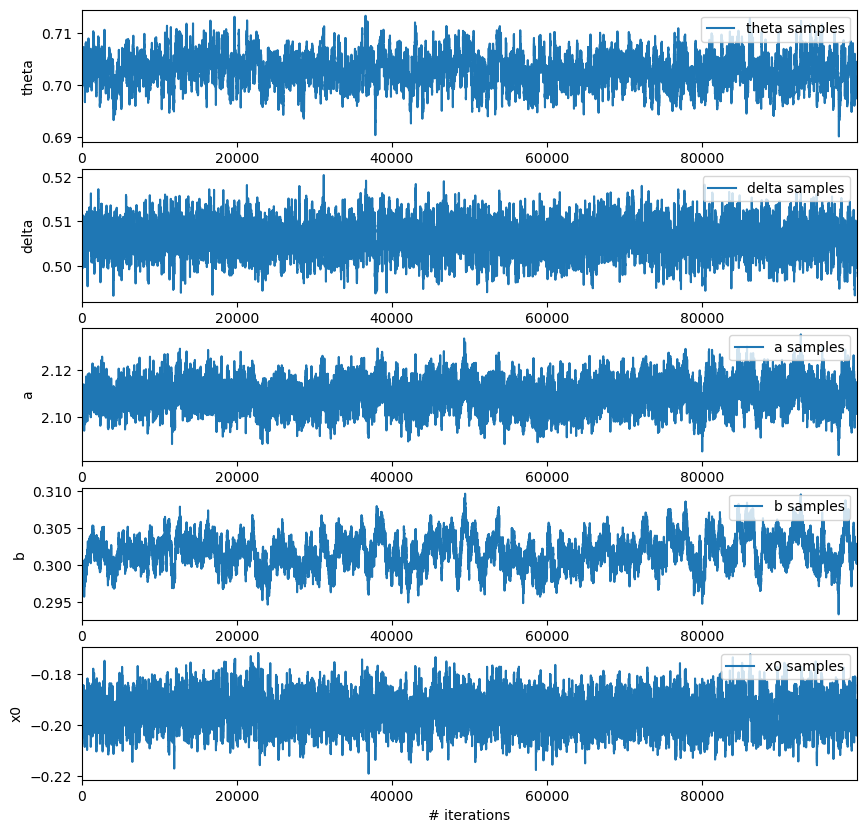

In [21]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
for i, name in enumerate(["theta", "delta", "a", "b", "x0"]):
    ax[i].plot(posterior_out[name], label=name + " samples")
    ax[i].legend(loc="upper right")
    ax[i].autoscale(axis="x", tight=True)
    ax[i].set_ylabel(name)
ax[4].set_xlabel("# iterations")

plt.show()

In [22]:
def run_two_chains(
    z0, n_draws=2000, n_burnIn=1000, rw_std=0.2, thin=1, seeds=(123, 456),
    jitter=None
):
    """
    Run two MCMC chains from overdispersed initializations.
    """
    z0 = np.asarray(z0, dtype=float)

    # make an overdispersed second init by jittering in u-space, then map back
    u0 = z_to_u(z0)
    if jitter is None:
        jitter = np.array([0.5, -0.5, 0.5, -0.5, 0.5], dtype=float)
    else:
        jitter = np.asarray(jitter, dtype=float)
        if jitter.shape != (5,):
            raise ValueError("jitter must be length-5 to match (u_theta, u_delta, u_a, u_b, u_x0).")

    z0_b = u_to_z(u0 + jitter)

    # run two chains
    results = []
    print("Running chain 1...")
    results.append(
        run_mcmc(
            z0,
            n_draws=n_draws,
            n_burnIn=n_burnIn,
            rw_std=rw_std,
            thin=thin,
            seed=seeds[0],
        )
    )
    print("Running chain 2...")
    results.append(
        run_mcmc(
            z0_b,
            n_draws=n_draws,
            n_burnIn=n_burnIn,
            rw_std=rw_std,
            thin=thin,
            seed=seeds[1],
        )
    )
    return results


In [ ]:
posterior_results = run_two_chains(z0, n_draws=50000, n_burnIn=10000, rw_std=0.012, thin=1)

Running chain 1...


Finish 10000 burn-in iterations, takes 2387.681 seconds.
Finish 50000 MCMC iterations, takes 14340.585 seconds.
Running chain 2...
Finish 10000 burn-in iterations, takes 2396.590 seconds.


In [ ]:
fname = "mcmc_diagnosis_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
with open(fname, "wb") as f:
    pickle.dump(posterior_results, f)

In [ ]:
def GelmanRubin_Rhat(param_chains):
    n_chains, n_draws = param_chains.shape
    n = n_draws // 2  # length of each split half
    x = np.concatenate(
        (param_chains[:, :n], param_chains[:, n : 2 * n]), axis=0
    )  # (2*n_chains, n)
    m = x.mean(axis=1)  # mean of each split
    s2 = x.var(axis=1, ddof=1)  # sample var of each split
    W = s2.mean()  # within-split variance
    B = n * m.var(ddof=1)  # between-split variance
    var_plus = ((n - 1) / n) * W + (B / n)
    return np.sqrt(var_plus / W)

In [ ]:
def diagnose(results):
    theta_chains = np.vstack([c["theta"] for c in results])
    delta_chains = np.vstack([c["delta"] for c in results])
    a_chains = np.vstack([c["a"] for c in results])
    b_chains = np.vstack([c["b"] for c in results])
    x0_chains = np.vstack([c["x0"] for c in results])
    C, N = theta_chains.shape

    # z_chains = np.stack(
    #     [theta_chains, delta_chains, a_chains, b_chains, x0_chains], axis=-1
    # )
    # u_chains = z_to_u(z_chains)
    # u_theta_chains, u_delta_chains, u_a_chains, u_b_chains, u_x0_chains = (
    #     u_chains[:, :, 0],
    #     u_chains[:, :, 1],
    #     u_chains[:, :, 2],
    #     u_chains[:, :, 3],
    #     u_chains[:, :, 4],
    # )

    # Gelman-Rubin R-hat statistics
    rhat_theta, rhat_delta, rhat_a, rhat_b, rhat_x0 = (
        GelmanRubin_Rhat(theta_chains),
        GelmanRubin_Rhat(delta_chains),
        GelmanRubin_Rhat(a_chains),
        GelmanRubin_Rhat(b_chains),
        GelmanRubin_Rhat(x0_chains),
    )

    print("[Gelman-Rubin R-hat]")
    print(f"  theta: {rhat_theta:.4f}")
    print(f"  delta: {rhat_delta:.4f}")
    print(f"  a    : {rhat_a:.4f}")
    print(f"  b    : {rhat_b:.4f}")
    print(f"  x0   : {rhat_x0:.4f}")

    fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
    for i, name in enumerate(["theta", "delta", "a", "b", "x0"]):
        for j in range(C):
            ax[i].plot(
                results[j][name], alpha=0.8, label=f"chain {j+1}, " + name + " samples"
            )
        ax[i].legend(loc="upper right")
        ax[i].autoscale(axis="x", tight=True)
        ax[i].set_ylabel(name)
    ax[4].set_xlabel("# iterations")

    plt.show()

[Gelman-Rubin R-hat]
  theta: 1.0039
  delta: 1.0021
  a    : 1.0075
  b    : 1.0143
  x0   : 1.0024


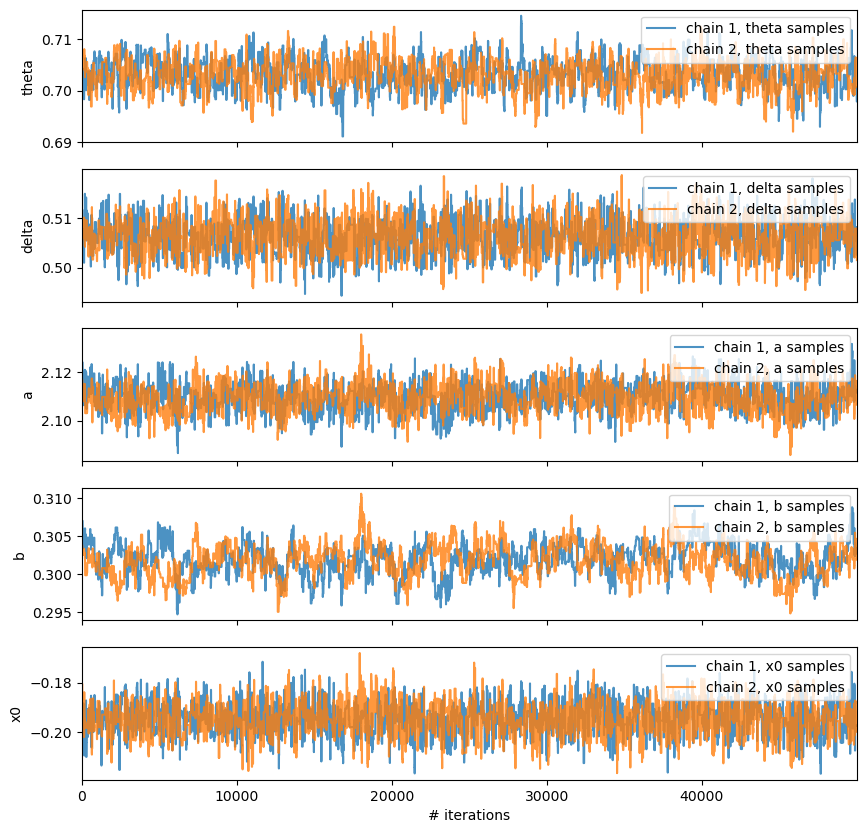

In [ ]:
diagnose(posterior_results)